In [1]:
from pathlib import Path
import pprint
import matplotlib.pyplot as plt
from dataclasses import asdict
import numpy as np
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import jax
# sns.set()

from meta_transformer.data import load_batches
from meta_transformer import utils, preprocessing
from meta_transformer.meta_model import MetaModelClassifier
from backdoors import paths

### Detecting backdoors

In [ ]:
# - plot ROC curve for each poison type
# - plot ROC curves for OOD test sets
# - compare AUROC to baseline (meta neural analysis and universal litmus patterns)

In [ ]:
NUM_SAMPLES = 50
POISON_TYPE = "random_border_pos_pattern"
chunk_size = 128

clean = load_batches(
    paths.TEST / "clean/clean_0", max_datapoints=NUM_SAMPLES)
backdoored = load_batches(
    paths.TEST / "backdoor" / POISON_TYPE, max_datapoints=NUM_SAMPLES)
clean = utils.tree_stack([x["params"] for x in clean])
backdoored = utils.tree_stack([x["params"] for x in backdoored])


@jax.jit
def process_base_models(params):
    return preprocessing.chunk(params, chunk_size)[0]

clean = jax.vmap(process_base_models)(clean)
backdoored = jax.vmap(process_base_models)(backdoored)

In [ ]:
# params  = load ...
# info = json.load...
# chunk_size = info["chunk_size"]
# model_config = info["model_config"]

d_model = 256
model = MetaModelClassifier(
       d_model=d_model,
        num_heads=max(1, int(d_model / 64)),
        num_layers=int(d_model / 42),
        dropout_rate=0.,
        use_embedding=False,
        in_factor=1.,
        out_factor=1.,
        init_scale=1.,
        attn_factor=.1,
)

In [ ]:
logits_on_clean = model.apply({"params": params}, clean)
logits_on_backdoored = model.apply({"params": params}, backdoored)
thresholds = np.arange(-5, 5)
fpr = {}
tpr = {}
for t in thresholds:
    fpr[t] = jnp.mean((logits_on_clean > t) == 1)
    tpr[t] = jnp.mean((logits_on_backdoored > t) == 1)
plt.plot(fpr, tpr, 'o', label="ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

### Comparison to CTC

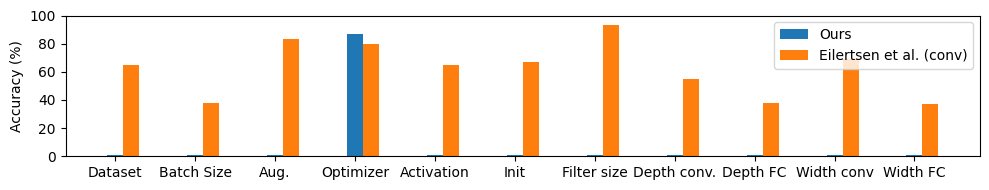

In [11]:
# first, remake ctc bar chart by copying their results by hand. then, next to every bar put our own results

ctc_conv_results = {
    "Dataset": 65,
    "Batch Size": 38,
    "Aug.": 83,
    "Optimizer": 79.5,
    "Activation": 65,
    "Init": 67,
    "Filter size": 93,
    "Depth conv.": 55,
    "Depth FC": 38,
    "Width conv": 69,
    "Width FC": 37,
}


our_results = {
    "Dataset": 1,
    "Batch Size": 1,
    "Aug.": 1,
    "Optimizer": 87,
    "Activation": 1,
    "Init": 1,
    "Filter size": 1,
    "Depth conv.": 1,
    "Depth FC": 1,
    "Width conv": 1,
    "Width FC": 1,
}

plt.figure(figsize=(10, 2.))
group_positions = np.arange(len(ctc_conv_results.keys()))
group_labels = ctc_conv_results.keys()


bar_width = 0.2
ax = plt.gca()
ax.bar(group_positions, our_results.values(), width=bar_width, label="Ours")
ax.bar(group_positions+bar_width, ctc_conv_results.values(), width=bar_width, label="Eilertsen et al. (conv)")
ax.set_xticks(group_positions)
ax.set_xticklabels(group_labels)
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, 100)
ax.legend()

plt.tight_layout()

figpath = "../../writeups/iclr-2023/figures/ctc-comparison.pdf"
plt.savefig(figpath, bbox_inches="tight")